In [ ]:
import pandas as pd

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv('bitcoin_data.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Basic info
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (1206274, 6)

Data Types:
Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
dtype: object

Missing Values:
Timestamp    0
Open         0
High         1
Low          1
Close        1
Volume       1
dtype: int64

Basic Statistics:
                           Timestamp          Open          High  \
count                        1206274  1.206274e+06  1.206273e+06   
mean   1970-01-01 00:00:01.361600250  1.689284e+02  1.691038e+02   
min    1970-01-01 00:00:01.325412060  3.800000e+00  3.800000e+00   
25%    1970-01-01 00:00:01.343506155  8.860000e+00  8.860000e+00   
50%    1970-01-01 00:00:01.361600250  2.983000e+01  2.983000e+01   
75%    1970-01-01 00:00:01.379694345  1.288000e+02  1.288300e+02   
max    1970-01-01 00:00:01.397788440  1.163000e+03  1.163000e+03   
std                              NaN  2.638314e+02  2.641503e+02   

                Low      

/tmp/ipython-input-3464538068.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


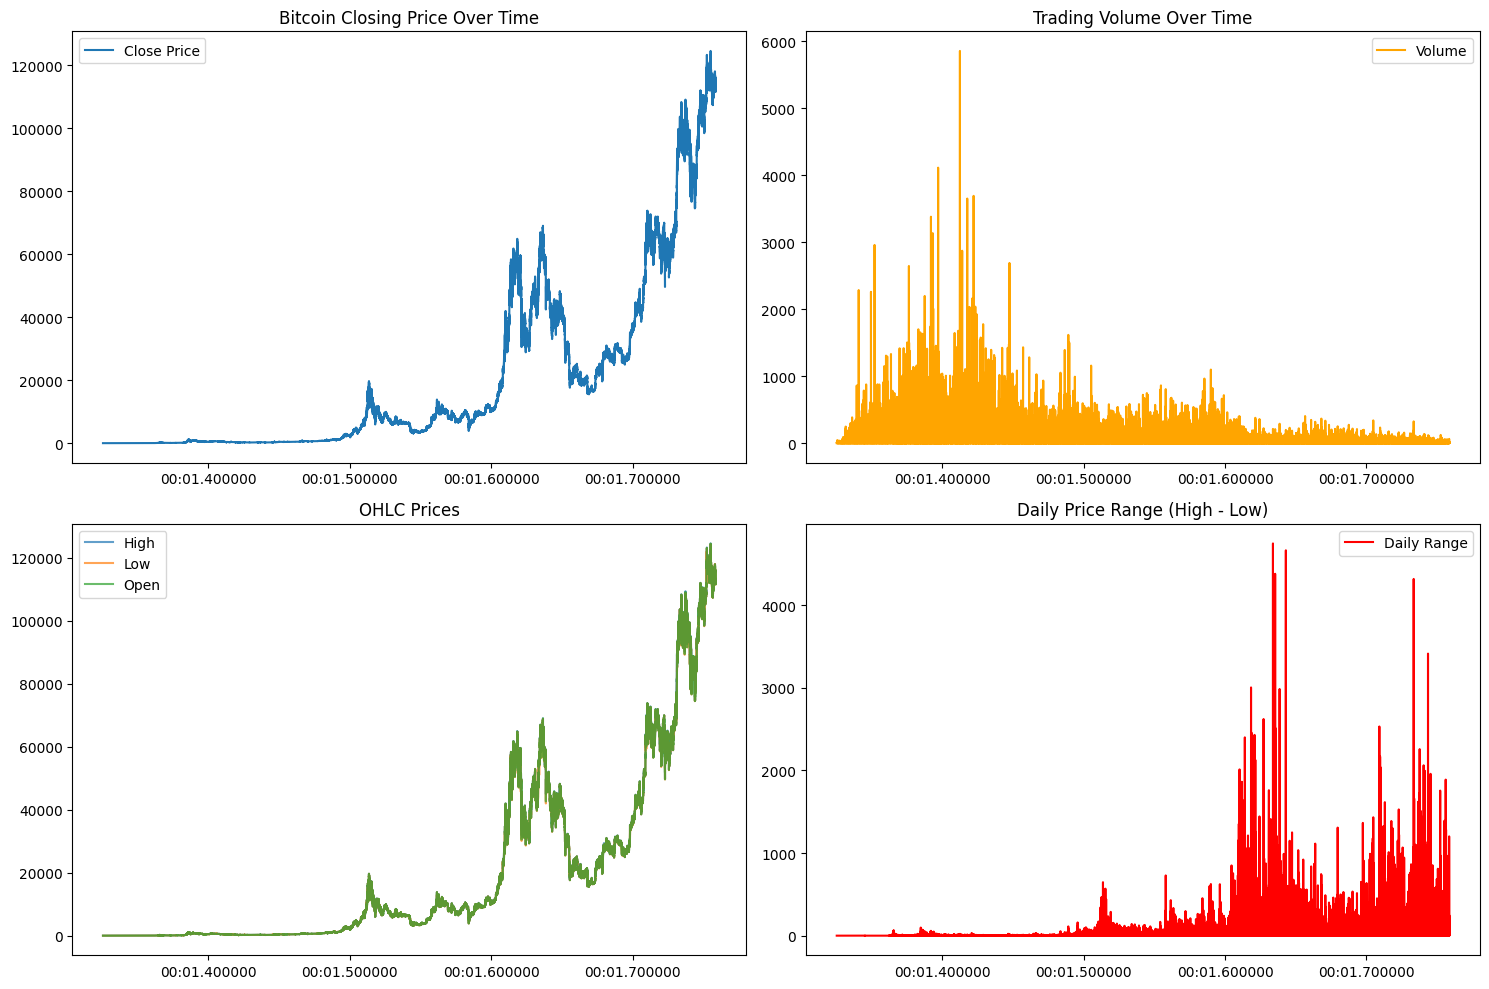

In [ ]:
# Set timestamp as index
df.set_index('Timestamp', inplace=True)

# Plot price trends
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df['Close'], label='Close Price')
plt.title('Bitcoin Closing Price Over Time')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df['Volume'], label='Volume', color='orange')
plt.title('Trading Volume Over Time')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df['High'], label='High', alpha=0.7)
plt.plot(df['Low'], label='Low', alpha=0.7)
plt.plot(df['Open'], label='Open', alpha=0.7)
plt.title('OHLC Prices')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot((df['High'] - df['Low']), label='Daily Range', color='red')
plt.title('Daily Price Range (High - Low)')
plt.legend()

plt.tight_layout()
plt.show()

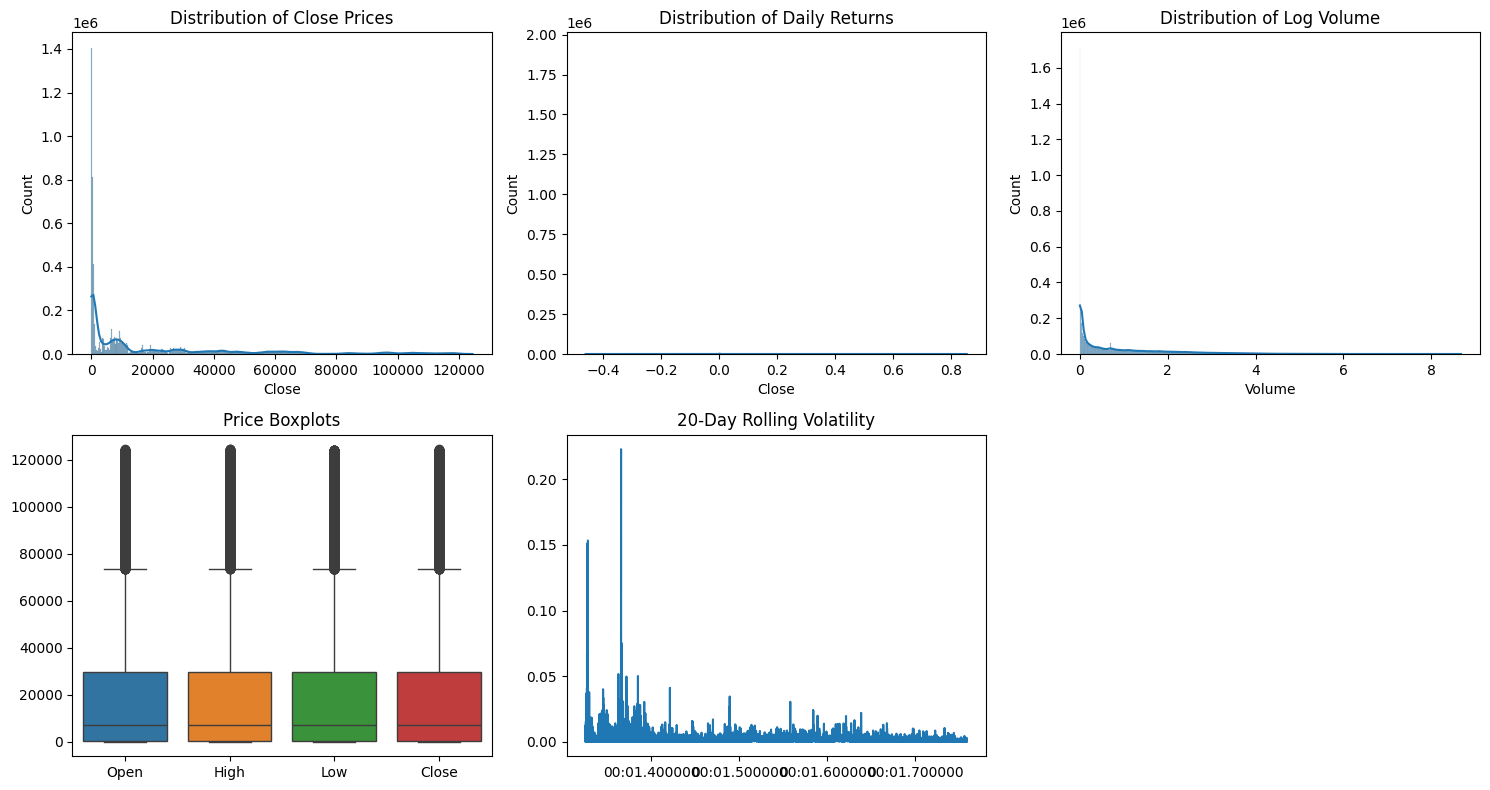

In [ ]:
# Distribution of prices and returns
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Close Prices')

plt.subplot(2, 3, 2)
daily_returns = df['Close'].pct_change().dropna()
sns.histplot(daily_returns, kde=True)
plt.title('Distribution of Daily Returns')

plt.subplot(2, 3, 3)
sns.histplot(np.log1p(df['Volume']), kde=True)
plt.title('Distribution of Log Volume')

plt.subplot(2, 3, 4)
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']])
plt.title('Price Boxplots')

plt.subplot(2, 3, 5)
# Volatility (rolling standard deviation of returns)
volatility = daily_returns.rolling(window=20).std()
plt.plot(volatility)
plt.title('20-Day Rolling Volatility')

plt.tight_layout()
plt.show()

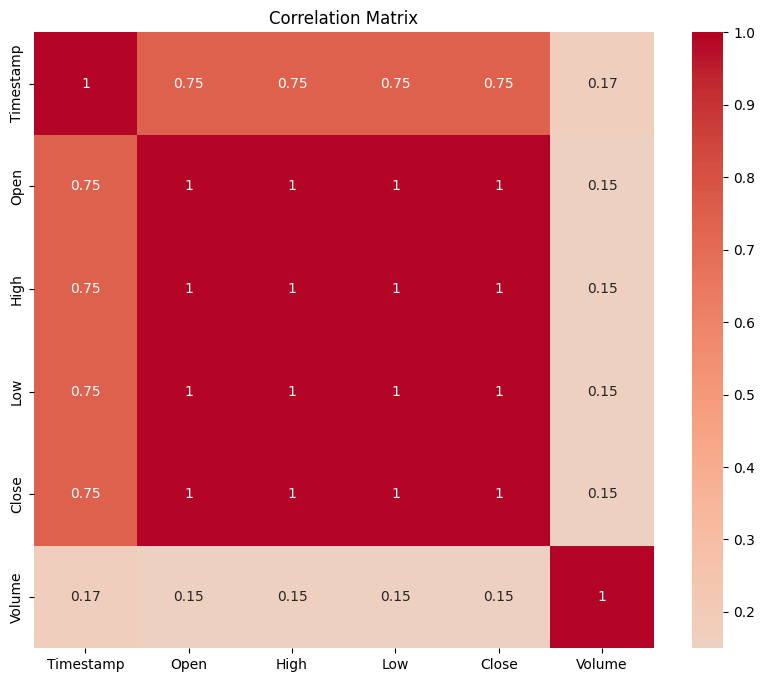

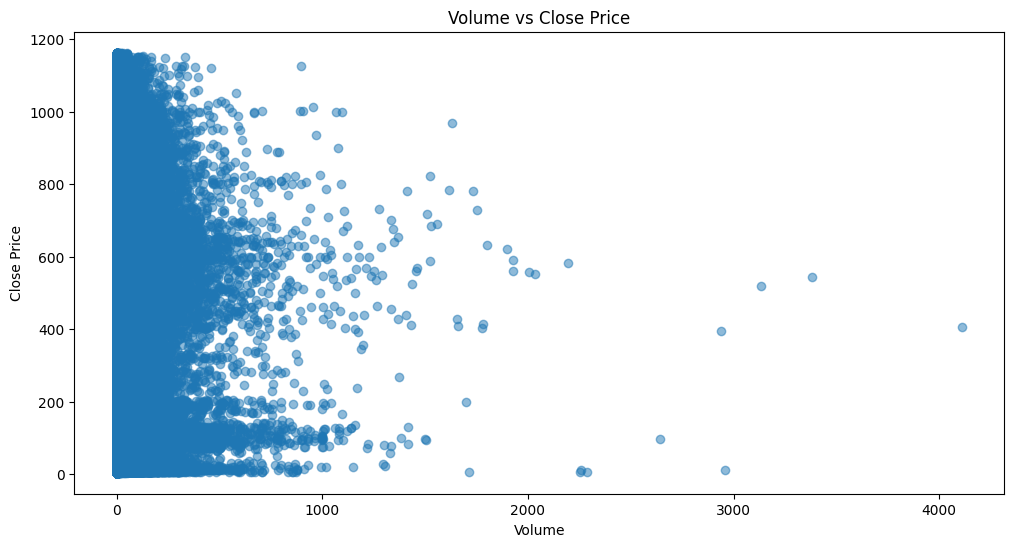

In [ ]:
# Correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# Volume-Price relationship
plt.figure(figsize=(12, 6))
plt.scatter(df['Volume'], df['Close'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Close Price')
plt.title('Volume vs Close Price')
plt.show()

In [ ]:
def create_technical_indicators(df):
    df = df.copy()

    # Price-based features
    df['price_range'] = df['High'] - df['Low']
    df['price_change'] = df['Close'] - df['Open']
    df['body_ratio'] = abs(df['Close'] - df['Open']) / (df['High'] - df['Low']).replace(0, 0.001)

    # Returns
    df['returns'] = df['Close'].pct_change()
    df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))

    # Moving averages
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_21'] = df['Close'].rolling(window=21).mean()
    df['MA_50'] = df['Close'].rolling(window=50).mean()

    # Moving average ratios
    df['MA_ratio_7_21'] = df['MA_7'] / df['MA_21']
    df['MA_ratio_7_50'] = df['MA_7'] / df['MA_50']

    # Volatility features
    df['volatility_7'] = df['returns'].rolling(window=7).std()
    df['volatility_21'] = df['returns'].rolling(window=21).std()

    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    df['RSI_14'] = calculate_rsi(df['Close'])

    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_histogram'] = df['MACD'] - df['MACD_signal']

    # Bollinger Bands
    df['BB_middle'] = df['Close'].rolling(20).mean()
    bb_std = df['Close'].rolling(20).std()
    df['BB_upper'] = df['BB_middle'] + (bb_std * 2)
    df['BB_lower'] = df['BB_middle'] - (bb_std * 2)
    df['BB_width'] = (df['BB_upper'] - df['BB_lower']) / df['BB_middle']
    df['BB_position'] = (df['Close'] - df['BB_lower']) / (df['BB_upper'] - df['BB_lower'])

    # Volume features
    df['volume_MA_7'] = df['Volume'].rolling(window=7).mean()
    df['volume_ratio'] = df['Volume'] / df['volume_MA_7']

    # Price position features
    df['price_position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low']).replace(0, 0.001)

    return df

# Apply feature engineering
df_features = create_technical_indicators(df)

/tmp/ipython-input-3127157935.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['returns'] = df['Close'].pct_change()


In [ ]:
df

,Open,High,Low,Close,Volume
Timestamp,,,,,
1970-01-01 00:00:01.325412060,4.58,4.58,4.58,4.58,0.000000
1970-01-01 00:00:01.325412120,4.58,4.58,4.58,4.58,0.000000
1970-01-01 00:00:01.325412180,4.58,4.58,4.58,4.58,0.000000
1970-01-01 00:00:01.325412240,4.58,4.58,4.58,4.58,0.000000
1970-01-01 00:00:01.325412300,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
1970-01-01 00:00:01.758671580,112061.00,112069.00,112019.00,112019.00,0.148851
1970-01-01 00:00:01.758671640,112020.00,112036.00,112020.00,112036.00,0.537612
1970-01-01 00:00:01.758671700,112036.00,112036.00,112035.00,112035.00,0.130133


 Time-Based Features

In [ ]:
def create_time_features(df):
    df.set_index('Timestamp', inplace=True)
    df = df.copy()


    # Extract time components
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Weekend and month-end flags
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_month_end'] = (df.index.is_month_end).astype(int)
    df['is_month_start'] = (df.index.is_month_start).astype(int)

    return df

df_features = create_time_features(df_features)

In [ ]:
def create_lag_features(df, target_col='Close', lags=[1, 2, 3, 5, 7, 14, 21]):
    df = df.copy()

    # Lag features for close price
    for lag in lags:
        df[f'close_lag_{lag}'] = df[target_col].shift(lag)
        df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)

    # Rolling statistics
    windows = [7, 14, 21]
    for window in windows:
        df[f'rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'rolling_max_{window}'] = df[target_col].rolling(window=window).max()
        df[f'rolling_volume_mean_{window}'] = df['Volume'].rolling(window=window).mean()

    # Price change over different periods
    df['price_change_1d'] = df[target_col].pct_change(1)
    df['price_change_7d'] = df[target_col].pct_change(7)
    df['price_change_30d'] = df[target_col].pct_change(30)

    return df

df_features = create_lag_features(df_features)

/tmp/ipython-input-3323802605.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['price_change_1d'] = df[target_col].pct_change(1)
/tmp/ipython-input-3323802605.py:20: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['price_change_7d'] = df[target_col].pct_change(7)
/tmp/ipython-input-3323802605.py:21: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['price_change_30d'] = df[target_col].pct_chan

In [ ]:
def create_target_variables(df, horizon=1):
    df = df.copy()

    # Future price prediction (next day's close)
    df['target_close'] = df['Close'].shift(-horizon)

    # Binary classification: price going up (1) or down (0)
    df['target_direction'] = (df['Close'].shift(-horizon) > df['Close']).astype(int)

    # Return prediction
    df['target_return'] = (df['Close'].shift(-horizon) - df['Close']) / df['Close']

    return df

df_features = create_target_variables(df_features, horizon=1)

In [ ]:
df_clean = df_features.dropna()

In [ ]:
print("Final dataset shape:", df_clean.shape)
print("\nColumns in final dataset:")
print(df_clean.columns.tolist())

Final dataset shape: (690587, 80)

Columns in final dataset:
['Open', 'High', 'Low', 'Close', 'Volume', 'price_range', 'price_change', 'body_ratio', 'returns', 'log_returns', 'MA_7', 'MA_21', 'MA_50', 'MA_ratio_7_21', 'MA_ratio_7_50', 'volatility_7', 'volatility_21', 'RSI_14', 'MACD', 'MACD_signal', 'MACD_histogram', 'BB_middle', 'BB_upper', 'BB_lower', 'BB_width', 'BB_position', 'volume_MA_7', 'volume_ratio', 'price_position', 'hour', 'day_of_week', 'day_of_month', 'week_of_year', 'month', 'quarter', 'year', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend', 'is_month_end', 'is_month_start', 'close_lag_1', 'volume_lag_1', 'close_lag_2', 'volume_lag_2', 'close_lag_3', 'volume_lag_3', 'close_lag_5', 'volume_lag_5', 'close_lag_7', 'volume_lag_7', 'close_lag_14', 'volume_lag_14', 'close_lag_21', 'volume_lag_21', 'rolling_mean_7', 'rolling_std_7', 'rolling_min_7', 'rolling_max_7', 'rolling_volume_mean_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_min_

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

# ----------------------------
# Step 1: Define Features & Target
# ----------------------------
drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
             'target_close', 'target_direction', 'target_return']

X = df_clean.drop(columns=drop_cols, errors='ignore')
y = df_clean['target_close']


# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Step 3: Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
}

# Step 4: Train & Evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = rmse = mean_squared_error(y_test, y_pred) ** 0.5
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# Show Comparison Table
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print(results_df)


               Model      RMSE       MAE        R²
0  Linear Regression  0.072866  0.026726  0.997611
2      Random Forest  1.188202  0.661836  0.364753
3  Gradient Boosting  1.189789  0.647375  0.363055
1      Decision Tree  1.194599  0.685568  0.357896


In [ ]:
import pickle

#reg_model = LinearRegression()
reg_model = models["Linear Regression"]
# Save regression model
with open("best_regression_model.pkl", "wb") as f:
    pickle.dump(reg_model, f)

print(" Best Regression model saved!")


In [ ]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 MB 1.3 MB/s eta 0:00:00


In [ ]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.2 MB/s eta 0:00:00


In [ ]:

import pandas as pd
import numpy as np
import pickle, time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
             'target_close', 'target_return', 'target_direction']

X = df_clean.drop(columns=drop_cols, errors='ignore')
y = df_clean['target_direction']


#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
## andle class imbalence

balancer = SMOTEENN(random_state=42)
X_train_bal, y_train_bal = balancer.fit_resample(X_train, y_train)

print( np.bincount(y_train_bal))


# Define Models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss')
}


# train & Evaluate
results = []
start = time.time()

for name, model in models.items():
    print(f" Training {name} ...")
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    results.append((name, acc, prec, rec, f1))
    print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

end = time.time()

# Compare Models
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1"])
print("\n--- Model Comparison ---")
print(results_df.sort_values("F1", ascending=False))

best_model_name = results_df.loc[results_df['F1'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

## Full Data

X_full = scaler.fit_transform(X)
best_model.fit(X_full, y)


# Save Best Model & Scaler

with open("best_bitcoin_classification_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("scaler_class.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Saved: best_bitcoin_classification_model.pkl & scaler_class.pkl")


# Final Evaluation
y_pred_final = best_model.predict(X_test)
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_final, digits=4))

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix ({best_model_name})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
